# Imports

In [ ]:
!pip install control
# Colab does not come with this library
import control
import cmath
# Allows you to make complex numbers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 432.8/432.8 kB 6.8 MB/s eta 0:00:00


In [ ]:
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
import numpy as np
from numpy.typing import ArrayLike
from typing import List
from typing import Tuple
from typing import Callable
# from typing import str
from math import pi

# Practicum 3 Code

## DCMotor
**DCMotorConfig**, **DCMotorDynamics**, and **DCMotor** are the classes we made for Practicum 3 to handle all of our DCMotor stuff. It's copied here, mostly unchanged from last week, for us to make a controller for it later! Since I thoroughly documented it last time, I won't repeat that here. Just for my own reference:
$$\begin{bmatrix}
x_1 \\ x_2 \\ x_3
\end{bmatrix}\equiv
\begin{bmatrix}
i \\
\theta \\
\dot{\theta}
\end{bmatrix}$$

In [ ]:
from dataclasses import dataclass
@dataclass
class DCMotorConfig:
  """Store constant values for a DC Motor.
  
  R: float: resistance (Ohms)
  L: float: inductance (Henry)
  b: float: dampening (Nms)
  J: float: moment of inertia (kgm^2)
  K_m: float: back emf constant
  K_tau: float: motor torque constant"""
  R: float
  L: float
  b: float
  J: float
  Km: float
  Ktau: float

  
class DCMotorDynamics:
  """Dynamics for a DC motor."""
  def __init__(self, motor_cfg: DCMotorConfig) -> None:
    """Create A and B matrices from the motor_cfg.
    
    motor_cfg: DCMotorConfig: dc motor config constants"""
    self.A = np.array([[-1*motor_cfg.R/motor_cfg.L, 0, -1*motor_cfg.Km/motor_cfg.L],
                       [0, 0, 1],
                       [motor_cfg.Ktau/motor_cfg.J, 0, -1*motor_cfg.b/motor_cfg.J]])
    self.B = np.array([[1/motor_cfg.L],
                       [0],
                       [0]])
  def __call__(self, x: ArrayLike, u: float) -> ArrayLike:
    """Perform xdot = Ax+Ub.
    
    x: ArrayLike: x
    u: float: input"""
    a_term = np.dot(self.A,x)
    b_term = self.B*u
    return a_term + b_term

class DCMotor:
  """Wrapper that abstracts away DCMotorDynamics."""
  def __init__(self, cfg: DCMotorConfig) -> None:
    """Inits dynamics.
    
    cfg: DCMotorConfig: dc motor config constants"""
    self.config = cfg
    self.dynamics = DCMotorDynamics(cfg)
    self.C = np.array([[0, 1, 0]])
  
  def output(self, x: ArrayLike) -> float:
    """Returns theta.
    
    x: ArrayLike: x"""
    return self.C@x

## State Feedback Regulator
**StateFeedbackRegulator** implements a state feedback controller, using passed vales for $K$, $K_f$, and setpoint (or $r$).
![State Feedback Regulator](https://drive.google.com/uc?export=view&id=1GBiB4joBPKAaFGgXIB_-vvPn0LA6DLKV)
$$\text{Figure taken from page 7-10 of FBS}$$

* **init** stores the constant values for $K$, $K_f$, and **setpoint** as member variables.
* **call** function implements state feedback control. It takes a measurement, $x$, as an argument and returns the input value. $u$. It implements:
$u=-kx+k_f*r$

A state feedback controller essentially takes the current output, or *feedback*, of our system and uses that to adjust the state of said system. It does this using closed loop poles / eigenvalues; providing an input to achieve a stable output reaching the desired setpoint, $r$. 

In theory, poles are chosen for desired system characteristics. This week we're arbitrarily using poles Dr. Martin has provided for us and seeing how they affect our system, but next week we'll be implementing a way to design our own!

In [ ]:
class StateFeedbackRegulator:
  def __init__(self,
               K: ArrayLike,
               k_f: float,
               setpoint: float) -> None:
    """Store K, k_f, and setpoint for use by the __call__ routine."""
    self.k = K
    self.k_f = k_f
    self.setpoint = setpoint

  def __call__(self, x: ArrayLike) -> float:
    """Compute the state feedback regulator as discussed in class
    Note: u should be a scalar since this is a single input system."""
    return -1 * self.k @ x +self.k_f*self.setpoint


One of the constants of our **StateFeedbackRegulator** class is $k_f$, which needs to be passed to the constructor. **feedforward_gain()** implents the following equation:
$$k_f=\frac{-1}{C(A-BK)^{-1}B}$$
It basically starts from the innermost part of the equation in the denominator and works its way back out.

In [ ]:
def feedforward_gain(K: ArrayLike,
                     A: ArrayLike,
                     B: ArrayLike,
                     C: ArrayLike) -> float:
  """Calculate the feedforward gain."""
  denom_temp = (A-B@K)
  denom_temp = np.linalg.inv(denom_temp)
  denom_temp = C@denom_temp
  denom = denom_temp@B
  return -1/denom

## Integration
These are my integration routines copy and pasted from Practicum 3! I won't repeat myself here.

In [ ]:
def rk2_step(dyn_func: Callable,
             u_func: Callable,
             x: ArrayLike,
             t: float,
             delta_t: float) -> ArrayLike:
  """Computing f1, f2, and x_k_1. Contains a workaroud
  to the fact that I misunderstood how to write this simulate
  function day1, and have been working with row vectors since,
  when in reality I should've been using columns.
  
  dyn_func: Callable: function being integrated
  u_func: Callable: input function
  x: ArrayLike: x_k value using to estimate x_k_1
  t: float: current time 
  delta_t: float: time step"""
  # Converting the input from a column to a row vector
  x = np.atleast_2d(x).T
  
  f_1 = dyn_func(x=x,u=u_func(t))
  f_2 = dyn_func(x=x + delta_t/2*f_1, u=u_func(t+delta_t/2))

  x_k_1 = x + delta_t*f_2
  # Converting the output from a row to a column vector
  x_k_1 = x_k_1.T
  return x_k_1

def simulate(plant, 
             controller,
             x_0: ArrayLike,
             t_0: float,
             t_f: float,
             delta_t: float) -> Tuple[ArrayLike, ArrayLike]:
  """Generalized integrator function that uses a
  stepper function to be more modular.
  
  plant: what we are controlling
  controller: controller from which input is received
  x_0: ArrayLike: initial conditions
  t_0: float: initial time
  t_f: float: final time
  delta_t: float: time step
  
  returns t, x, u"""
  # Generate our t values
  t_vals = np.arange(start=t_0, 
                      stop=t_f+delta_t, 
                      step=delta_t)

  # Creating our result array
  x_vals = np.zeros([len(t_vals), np.shape(x_0)[0]])
  x_vals[0] = x_0

  # Now we need U history
  u_func = lambda t, state=x_vals[0]: controller(state)
  u_vals = np.zeros(len(t_vals))

  # Using our stepper
  for i in range(1, len(t_vals)):
    u_func = lambda t, state=x_vals[i-1]: controller(state)
    u_vals[i] = u_func(t_vals[i-1])
    x_vals[i] = rk2_step(dyn_func=plant.dynamics,
                         u_func=u_func,
                         x=x_vals[i-1],
                         t=t_vals[i-1],
                         delta_t=delta_t)
  return t_vals, x_vals, u_vals

## DC Motor constants
Apparently, using our old DC motor constants caused some strange math weirdness with this week's poles, so we're updating our constants to be about an order of magnitude larger in most cases.

Old values:
$$R=1.8\Omega, L=0.85E*10^{-2}H, J=0.032, b=0.035$$
New values:
$$R=10\Omega, L=0.85H, J=0.32, b=0.35$$

In [ ]:
cfg = DCMotorConfig(R=10, L=0.85, Km=4.6, Ktau=6.2, b=0.35, J=0.32)
dcmotor1 = DCMotor(cfg=cfg)
duration = 3
delta_t = 0.001

A = dcmotor1.dynamics.A
B = dcmotor1.dynamics.B
C = dcmotor1.C

# LQR Design and Performance Analysis

## Plotting
Per usual, I made a plotting function. This one is copy-pasted last week, with modifications made for Evaluation 1.

In [ ]:
def eval1_plot(plant,
               controllers: list,
               labels: list,
               x_0: ArrayLike,
               duration: float, 
               delta_t: float,
               title: str):
  """Plot theta over time on a grid.
  
  plant: plant to be plotted
  controller: controller to be plotted
  x_0: ArrayLike: initial conditions to be plotted
  duration: float: length of time to integrate over
  delta_t: float: time step value to plot
  title: str: title for the plot"""
  # Create a new figure
  fig = plt.figure(figsize=(10,7))
  axs = fig.subplots(1,2)
  colors = ["green","blue","purple"]
  
  
  for i, controller in enumerate(controllers):
    # Simulate
    t_vals, x_vals, u_vals = simulate(plant=plant,
                              controller=controller,
                              x_0=x_0,
                              t_0=0,
                              t_f=duration,
                              delta_t=delta_t)
    # Plot
    # color = "green"
    # fig, ax1 = plt.subplots
    axs[0].set_xlabel("Time $(s)$")
    axs[0].set_ylabel("Position $(\Theta)$")
    axs[0].plot(t_vals, [x[1] for x in x_vals], color=colors[i], label=labels[i])
    axs[0].tick_params(axis='y')
    axs[0].minorticks_on
    axs[0].grid(which='major', color='#AAAAAA', linewidth=1.0)
    axs[0].grid(which='minor', linewidth=0.8)
    axs[0].set_title("Output")

    # color = '#00118f'
    axs[1].set_ylabel(r"Input (V)")
    axs[1].set_xlabel("Time $(s)$")
    axs[1].plot(t_vals, u_vals, color=colors[i], label=labels[i])
    axs[1].tick_params(axis='y')
    axs[1].minorticks_on
    axs[1].grid(visible=True, which='major', color='#AAAAAA', linewidth=1.0)
    axs[1].grid(visible=True, which='minor', linewidth=0.8)
    axs[1].set_title("Control Signal")
  
  axs[0].legend()
  axs[1].legend()
  # Adding appropriate labels
  fig.suptitle(title)
  fig.tight_layout()

## Evaluation 1
Since we only have one input, given a $u_{max}$, we can calculate our $Q_u$ using the following equation:
$$Q_u=\frac{1}{u_{max}^2}$$

So for our first set of plots, with $u_{max}=9V$, we'll have $Q_u=\frac{1}{81}$, with varying $Q_x$ as shown below:
$$\begin{array}{ |c|c|c| } 
 \hline
1 & 2 & 3 \\
\hline
Q_x = \begin{bmatrix}
1 && 0 && 0 \\
0 && 1 && 0 \\
0 && 0 && 1 \\
\end{bmatrix} & 
 Q_x = \begin{bmatrix}
0.1 && 0 && 0 \\
0 && 1 && 0 \\
0 && 0 && 0.1 \\
\end{bmatrix}  &  
 Q_x = \begin{bmatrix}
0 && 0 && 0 \\
0 && 1 && 0 \\
0 && 0 && 0 \\
\end{bmatrix}  \\
 \hline
\end{array}$$

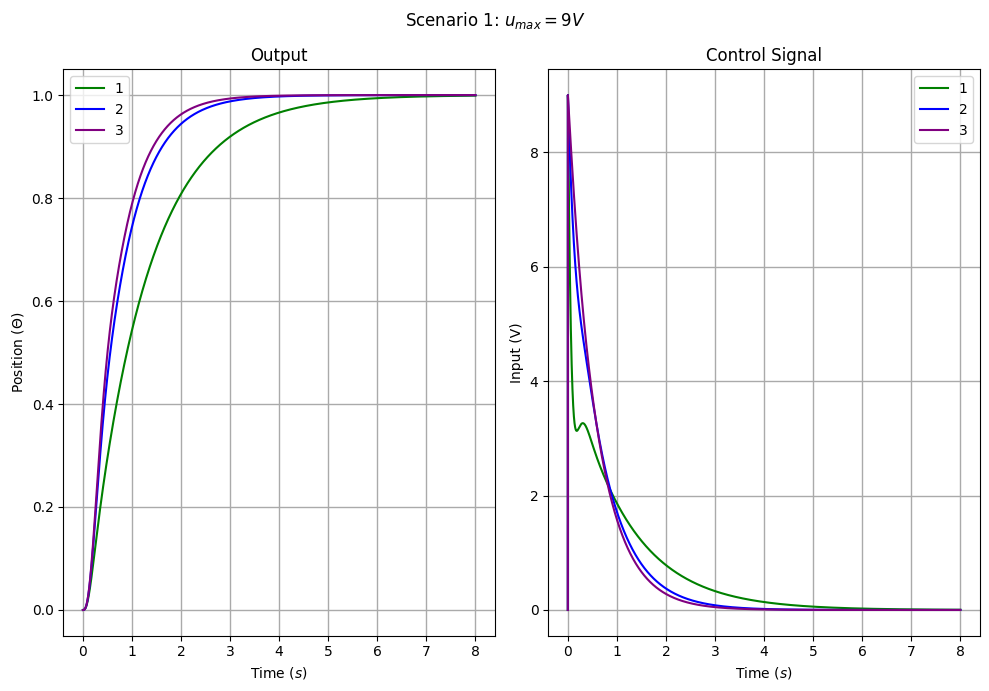

In [ ]:
Q_u = 1/81
Q_x_1 = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
Q_x_2 = [[0.1, 0, 0], [0, 1, 0], [0, 0, 0.1]]
Q_x_3 = [[0, 0, 0], [0, 1, 0], [0, 0, 0]]
K_1, S_1, E_1 = control.lqr(A, B, Q_x_1, Q_u)
K_2, S_2, E_2 = control.lqr(A, B, Q_x_2, Q_u)
K_3, S_3, E_3 = control.lqr(A, B, Q_x_3, Q_u)
K_f_1 = feedforward_gain(K=K_1, A=A, B=B, C=C)
K_f_2 = feedforward_gain(K=K_2, A=A, B=B, C=C)
K_f_3 = feedforward_gain(K=K_3, A=A, B=B, C=C)
title = 'Scenario 1: $u_{max}=9V$'
duration = 8
eval1_plot(plant=dcmotor1,
     controllers=[StateFeedbackRegulator(K=K_1, k_f=K_f_1, setpoint=1),
                  StateFeedbackRegulator(K=K_2, k_f=K_f_2, setpoint=1),
                  StateFeedbackRegulator(K=K_3, k_f=K_f_3, setpoint=1)],
     labels=["1", "2", "3"],
     x_0=np.array([0, 0, 0]),
     duration=duration,
     delta_t=delta_t,
     title=title)

Now $u_{max}=12V$, $Q_u=\frac{1}{144}$, with the same $Q_x$ values as before:
$$\begin{array}{ |c|c|c| } 
 \hline
1 & 2 & 3 \\
\hline
Q_x = \begin{bmatrix}
1 && 0 && 0 \\
0 && 1 && 0 \\
0 && 0 && 1 \\
\end{bmatrix} & 
 Q_x = \begin{bmatrix}
0.1 && 0 && 0 \\
0 && 1 && 0 \\
0 && 0 && 0.1 \\
\end{bmatrix}  &  
 Q_x = \begin{bmatrix}
0 && 0 && 0 \\
0 && 1 && 0 \\
0 && 0 && 0 \\
\end{bmatrix}  \\
 \hline
\end{array}$$

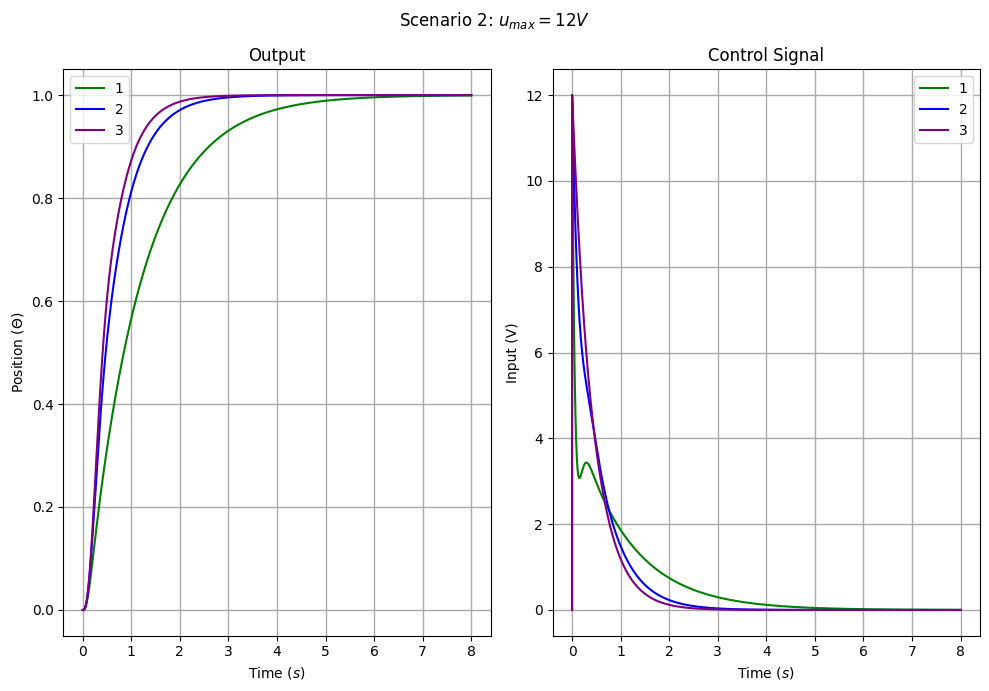

In [ ]:
Q_u = 1/144
K_1, S_1, E_1 = control.lqr(A, B, Q_x_1, Q_u)
K_2, S_2, E_2 = control.lqr(A, B, Q_x_2, Q_u)
K_3, S_3, E_3 = control.lqr(A, B, Q_x_3, Q_u)
optimal_poles = E_1
K_f_1 = feedforward_gain(K=K_1, A=A, B=B, C=C)
K_f_2 = feedforward_gain(K=K_2, A=A, B=B, C=C)
K_f_3 = feedforward_gain(K=K_3, A=A, B=B, C=C)
title = 'Scenario 2: $u_{max}=12V$'
eval1_plot(plant=dcmotor1,
     controllers=[StateFeedbackRegulator(K=K_1, k_f=K_f_1, setpoint=1),
                  StateFeedbackRegulator(K=K_2, k_f=K_f_2, setpoint=1),
                  StateFeedbackRegulator(K=K_3, k_f=K_f_3, setpoint=1)],
     labels=["1", "2", "3"],
     x_0=np.array([0, 0, 0]),
     duration=duration,
     delta_t=delta_t,
     title=title)

### Reflection
**Describe how you think each relates to the states in the system. Which physical $Q_x$ quantities are affected by each choice of $Q_x$?**

Based on the penalized states equation: $$x^TQ_xx$$ and our state declarations for our system:
$$\begin{bmatrix}
x_1 \\ x_2 \\ x_3
\end{bmatrix}\equiv
\begin{bmatrix}
i \\
\theta \\
\dot{\theta}
\end{bmatrix}$$
**$Q_x$ 1** has current $i$, angle $\theta$, and velocity $\dot{\theta}$ all weighted the same, as they are all 1s.

**$Q_x$ 2** has current $i$ and velocity $\dot{\theta}$ weighted low at 0.1 with angle $\theta$ weighted at 1.

**$Q_x$ 3** has current $i$ and velocity $\dot{\theta}$ weighted at nothing (0) with angle $\theta$ weighted at 1.

**Describe what you see happening to your output based on each $Q_x$. Do you see any $Q_x$ trends? How do you think changing $Q_x$ affects your system response? What qualitatively happens to the control input signal as you modify $Q_x$?**

Each $Q_x$ progressively has a shorter and shorter rise time and settling time - getting closer to the setpoint faster and faster. This trend is because our $Q_x$ values weight $\theta$ progressively more and more, and that's what our output is. As the rise and settling time progressivle decrease, our control signal falls off faster and faster - which intuitively makes sense, since as the output approaches setpoint, we expect to see control signal approach 0.

**Compare the control signals between the $9V$ and $12V$ cases. Do the responses respect constraints? Do you see any qualitative differences between these cases?**

Both responses respect their constraints. The 12V constraints are met almost exactly, while the 9V constraint has some breathing room, as the control signal peaks at about 8.5V. There aren't really any qualitative differences in the control signals between scenarios other than the magnitudes - the curves look about the same.

## Optimal Pole Computation
Here, we're going to verify that `control.lqr()` is giving us the output we expect for our optimal pole values at the following conditions:
$$u_{max}=12V \qquad
Q_x = \begin{bmatrix}
1 && 0 && 0 \\
0 && 1 && 0 \\
0 && 0 && 1 \\
\end{bmatrix}$$
We know state feedback works using the following equation:
$$A-BK_{opt}$$
So, below, we will compare the poles given to us by `control.lqr()` and the ones we get from the above equation.

In [ ]:
print(optimal_poles)
print(np.linalg.eig(A-B*K_1))

[-13.45709339+10.81255151j -13.45709339-10.81255151j
  -0.91786966 +0.j        ]
(array([-13.45709339+10.81255151j, -13.45709339-10.81255151j,
        -0.91786966 +0.j        ]), array([[-0.48627351+0.42527795j, -0.48627351-0.42527795j,
         0.00613828+0.j        ],
       [-0.03441237-0.02764977j, -0.03441237+0.02764977j,
        -0.73669864+0.j        ],
       [ 0.76205513+0.j        ,  0.76205513-0.j        ,
         0.67619334+0.j        ]]))


As you can see, in both outputs, we get the same three sets of poles: $$-13.457+10.813j \qquad -13.457-10.813j \qquad -0.918 + 0j$$

# Output Feedback via State Estimators

## Observability
To find out if a system is obvservable, we do something very similar to figuring out if it's controllable. We implemet the following equation for an n-dimensional system:
$$W_0=\begin{bmatrix}
C \\
CA \\
\vdots \\
CA^{n-1}
\end{bmatrix}$$

This occurs in the following steps:
  1. Create a $W_0$ matrix that contains the first term, just C.
  ```
  W = C
  ```
  1. Enter for loop with boundary conditions based on the shape of A.
  ```
  for i in range (1, A.shape)
  ```
    1. Raise A to the power of the iterator.
    ```
    A = np.matrix_power(A, i)
    ```
    1. Multiply it by C.
    ```
    A = C@A
    ```
    1. Horizontally stack this onto the W matrix.
    ```
    W = np.hstack(W, A)
    ```

In [ ]:
def obsv(A: ArrayLike, C: ArrayLike) -> ArrayLike:
  """Comput the observability grammian.
  
  A: ArrayLike: A matrix
  C: ArrayLike: C matrix"""
  W = C
  for i in range(1, A.shape[0]):
    temp_a = np.linalg.matrix_power(A, i)
    W = np.vstack((W, C@temp_a))
  return W

Testing **obsv()**: We can manually calculate the observability matrix for a couple systems and see if our function outputs the same.
$$A = \begin{bmatrix}
1 & 2 \\
0 & -1
\end{bmatrix} \qquad C = \begin{bmatrix}0 & 1\end{bmatrix}
\qquad W_0 = \begin{bmatrix}C \\ CA\end{bmatrix} $$

$$CA = \begin{bmatrix}0 & 1\end{bmatrix}\begin{bmatrix}
1 & 2 \\
0 & -1
\end{bmatrix} $$

$$CA = \begin{bmatrix}0 & -1\end{bmatrix}$$

$$W_{0_1}=\begin{bmatrix}0 & 1 \\ 0 & -1\end{bmatrix}$$

That's our first output! Now for the second:

$$A = \begin{bmatrix}
1 & 2 \\
0 & -1
\end{bmatrix} \qquad C = \begin{bmatrix}1 & 0\end{bmatrix}
\qquad W_0 = \begin{bmatrix}C \\ CA\end{bmatrix} $$

$$CA = \begin{bmatrix}1 & 0\end{bmatrix}\begin{bmatrix}
1 & 2 \\
0 & -1
\end{bmatrix} $$

$$CA = \begin{bmatrix}1 & 2\end{bmatrix}$$

$$W_{0_2}=\begin{bmatrix}1 & 0 \\ 1 & 2\end{bmatrix}$$

In [ ]:
w_1 = obsv(A=np.array([[1, 2], [0, -1]]), C=np.array([0, 1]))
w_2 = obsv(A=np.array([[1, 2], [0, -1]]), C=np.array([1, 0]))
print(f"W_0_1: \n{w_1}")
print(f"W_0_2: \n{w_2}")

W_0_1: 
[[ 0  1]
 [ 0 -1]]
W_0_2: 
[[1 0]
 [1 2]]


And success! Our observability matrix outputs from **obsv()** match what we calculated manually!

**is_obsv()** checks if a system is observable based on its observability matrix. This is done by calculating the determinant: if it is non-zero, the matrix is full rank, making it observable!

In [ ]:
def is_obsv(W: ArrayLike) -> bool:
  """Calculates determinate of C. If != 0,
  is full rank, and therefore observable."""
  return np.linalg.det(W) != 0

Once again, to test this, we will calculate the determinants of these observability matrices ourselves to make sure the output we're getting from **is_obsv()** is correct.

$$W_{0_1}=\begin{bmatrix}0 & 1 \\ 0 & -1\end{bmatrix} \qquad 
\begin{vmatrix}\begin{bmatrix}0 & 1 \\ 0 & -1\end{bmatrix}\end{vmatrix}= (0)(-1) - (1)(0) = 0
$$

With a determinant of 0, this matrix *does not have full rank*, meaning it is **NOT observable!**

$$W_{0_2}=\begin{bmatrix}1 & 0 \\ 1 & 2\end{bmatrix} \qquad 
\begin{vmatrix}\begin{bmatrix}1 & 0 \\ 1 & 2\end{bmatrix}\end{vmatrix}= (1)(2) - (0)(1) = 2
$$

With a non-zero determinant, this matrix *has full rank*, meaning it **IS observable!**

In [ ]:
print(f"W_0_1 is observable: {is_obsv(w_1)}")
print(f"W_0_2 is observable: {is_obsv(w_2)}")

W_0_1 is observable: False
W_0_2 is observable: True


The output from our **is_obsv()** function matches what we calculated manually!

## Evaluation 2
Now, we're going to check to see which configurations of our system are observable, by using our previously-defined functions.
$$\begin{bmatrix}
x_1 \\ x_2 \\ x_3
\end{bmatrix}\equiv
\begin{bmatrix}
i \\
\theta \\
\dot{\theta}
\end{bmatrix}$$
$$
\begin{array}{ |c|c|c| } 
 \hline
1 & 2 & 3 \\
\hline
 C = \begin{bmatrix}1 & 0 & 0\end{bmatrix}  & 
 C = \begin{bmatrix}0 & 1 & 0\end{bmatrix}  &  
 C = \begin{bmatrix}0 & 0 & 1\end{bmatrix}  \\
 \hline
\end{array}$$

In [ ]:
w_1 = obsv(A=A, C=np.array([1, 0, 0]))
w_2 = obsv(A=A, C=np.array([0, 1, 0]))
w_3 = obsv(A=A, C=np.array([0, 0, 1]))

print(f"Is 1 observable? {is_obsv(w_1)}")
print(f"Is 2 observable? {is_obsv(w_2)}")
print(f"Is 3 observable? {is_obsv(w_3)}")

Is 1 observable? False
Is 2 observable? True
Is 3 observable? False


These outputs make sense. The only case this system is observable is when our output is position. If we're measuring speed, when we integrate back to get position, there's an unknown constant that we're missing. Current alone doesn't tell us anything about the state of the speed or position of the motor. 

# State Estimation
For State Estimation, we will start by calculating the estimate gain, $L$. To do this, we can re-use *acker()* by transposing $A$ and $C$ and transposing the result. We also need to multiply our optimal poles by a constant, typically 2-5. I chose 3 to be right in the middle.

In [ ]:
A = dcmotor1.dynamics.A
B = dcmotor1.dynamics.B
C = dcmotor1.C
obsv_poles = optimal_poles * 3
print(f"{obsv_poles=}{optimal_poles=}")
L = control.acker(A.T, C.T, obsv_poles).T # numpy arrays are transposed via .T

obsv_poles=array([-40.37128017+32.43765452j, -40.37128017-32.43765452j,
        -2.75360899 +0.j        ])optimal_poles=array([-13.45709339+10.81255151j, -13.45709339-10.81255151j,
        -0.91786966 +0.j        ])


## State Estimator
Up until this point, we've been operating under the assumption that we live in a perfect world and can view our system's state. Unfortunately, this is not typically true, as we've seen exploring *observability*.

So, for this reason it is necessary for us to build a state estimator that can estimate our state!  Then our state feedback regulator can use that to drive the output we expect. The diagram of our system with a state estimator integrated is pictured below.
![State Estimator](https://drive.google.com/uc?export=view&id=11Y_ieXCBKQDxxtZ531kdINlwb88teDXx)
$$\dot{\hat{x(t)}}=A\hat{x(t)}+Bu(t)+L(y-C\hat{x(t)})$$

Now that we know what it looks like, let's build it!

In [ ]:
class StateEstimator:
  def __init__(self, plant, L: ArrayLike) -> None:
    """Store the plant (e.g. a DCMotor instance) and the
    estimate gain matrix, L as member variables
    
    plant: plant to estimate the state of
    L: ArrayLike: estimate gain matrix"""
    self.plant = plant
    self.L = L
  def __call__(self, xhat: ArrayLike, u: float, y: float) -> ArrayLike:
    """Use the current state estimate, control signal, and measurement
    to compute the estimate dynamics!
    
    xhat: ArrayLike: xhat
    u: float: input
    y: float: output"""
    A = self.plant.dynamics.A
    B = self.plant.dynamics.B
    C = self.plant.C
    return A@xhat + B*u +L*(y-C@xhat)

Now I'm going to test what my estimator outputs and compare it with Abdul, who's the only person still here on the first week of Practicum 4....

In [ ]:
L = control.acker(A.T, C.T, optimal_poles).T # numpy arrays are transposed via .T
estimator = StateEstimator(plant=dcmotor1, L=L)
print(estimator(xhat=np.array([[0], [0], [0]]), u=12, y=4))

[[-323.56424946]
 [  59.89440226]
 [  49.80151075]]


After we verified that we were using the same DC motor constants (he was still using the old ones on accident!), our outputs match!

## Final simulate function
I'm told this is the last time I'll be editing this function... I'm not sure I believe it just yet.

It's the same structure as before: creating a bunch of result arrays, and then entering a loop and iterating using a stepper function. The only real difference in this one is that now, our input function **u_func()** is being fed $\hat{x}$ instead of $x$, to *simulate* (haha) a closer to real-world situation where we can't perfectly measure the state of our system.

We're also now returning $\hat{x}$ and $y$ alongside $x$, $t$, and $u$ to plot them against each other to see how well our estimator is working.

In [ ]:
def simulate_final(plant, 
                   plant_est,
                   controller,
                   x_0: ArrayLike,
                   xhat_0: ArrayLike,
                   t_0: float,
                   t_f: float,
                   delta_t: float) -> Tuple[ArrayLike, ArrayLike, ArrayLike, ArrayLike, ArrayLike]:
  """Generalized integrator function that uses a
  stepper function to be more modular.
  
  plant: what we are controlling
  plant_est: the estimator of what we're controlling
  controller: controller from which input is received
  x_0: ArrayLike: initial conditions
  xhat_0: ArrayLike: initial conditions of the estimate
  t_0: float: initial time
  t_f: float: final time
  delta_t: float: time step
  
  returns: time, x, xhat, u, y"""
  # Generate our t values
  t_vals = np.arange(start=t_0, 
                      stop=t_f+delta_t, 
                      step=delta_t)

  # Creating our result array
  x_vals = np.zeros([len(t_vals), np.shape(x_0)[0]])
  x_vals[0] = x_0

  # Creating our x_hat array
  x_hat_vals = np.zeros([len(t_vals), np.shape(xhat_0)[0]])
  x_hat_vals[0] = xhat_0

  # Creating our output array
  y_vals = np.zeros(len(t_vals))
  y_vals[0] = plant.output(x_0)

  # Now we need U history
  u_vals = np.zeros(len(t_vals))

  # Using our stepper
  for i in range(1, len(t_vals)):
    y_vals[i] = plant.output(x_vals[i-1])
    u_func = lambda t, state=x_hat_vals[i-1]: controller(state)
    u_vals[i] = u_func(t_vals[i-1])

    est_func = lambda x, u, y=y_vals[i]: plant_est(x, u, y)
    
    x_hat_vals[i] = rk2_step(dyn_func=est_func,
                             u_func=u_func,
                             x=x_hat_vals[i-1],
                             t=t_vals[i-1],
                             delta_t=delta_t)
    
    x_vals[i] = rk2_step(dyn_func=plant.dynamics,
                         u_func=u_func,
                         x=x_vals[i-1],
                         t=t_vals[i-1],
                         delta_t=delta_t)
    
  return t_vals, x_vals, x_hat_vals, u_vals, y_vals

## Final Plot function :(
Made one more plot function! I can't believe this semester is almost over...

In [ ]:
def plot_final(plant,
               controller,
               plant_est,
               x_0: ArrayLike,
               xhat_0: ArrayLike,
               duration: float, 
               delta_t: float):
  """Plot theta over time on a grid.
  
  plant: plant to be plotted
  plant_est: estimator for the plant
  controller: controller to be plotted
  x_0: ArrayLike: initial conditions to be plotted
  xhat_0: ArrayLike: initial conditions of the plotter
  duration: float: length of time to integrate over
  delta_t: float: time step value to plot"""
  # Create a new figure
  fig = plt.figure(figsize=(15,5))
  axs = fig.subplots(1,4)
  colors = ["green", "purple", "blue"]
  ylabels = ["Current ($A$)",
             "Position $(radians)$",
             "Velocity $(radians/s)$"]
  legend_labels = [("$x_1$", "$\hat{x_1}$"),
                   ("$x_2$", "$\hat{x_2}$"),
                   ("$x_3$", "$\hat{x_3}$")]
  titles = ["$i$", "$\\theta$", "$\dot{\\theta}$"]
  
  
  # Simulate
  t_vals, x_vals, x_hat_vals, u_vals, y_vals = simulate_final(plant=plant,
                                                              controller=controller,
                                                              plant_est=plant_est,
                                                              x_0=x_0,
                                                              xhat_0=xhat_0,
                                                              t_0=0,
                                                              t_f=duration,
                                                              delta_t=delta_t)
  # X values
  for i in range(len(colors)):
    axs[i].set_xlabel("Time $(s)$")
    axs[i].set_ylabel(ylabels[i])
    axs[i].plot(t_vals, [x[i] for x in x_vals], color=colors[i], label=legend_labels[i][0])
    axs[i].plot(t_vals, [x[i] for x in x_hat_vals], color=colors[i], linestyle="dashed", label=legend_labels[i][1])
    axs[i].grid(visible=True, which='major', color='#AAAAAA', linewidth=1.0)
    axs[i].legend()
    axs[i].axhline(y=0, color='k', linestyle="dashed")
    axs[i].set_title(titles[i])

  # Control Signals
  axs[3].set_ylabel(r"Input (V)")
  axs[3].set_xlabel("Time $(s)$")
  axs[3].plot(t_vals, u_vals, color="turquoise", label="$U$")
  axs[3].grid(visible=True, which='major', color='#AAAAAA', linewidth=1.0)
  axs[3].legend()
  axs[3].axhline(y=0, color='k', linestyle="dashed")
  axs[3].set_title("Control Signal")
  
  # Adding appropriate labels
  title = "$\hat{x_0}$ = "
  title += f"{xhat_0}"
  
  fig.suptitle(title)
  fig.tight_layout()

## Evaluation 3
Alright... the final evaluation of the semester! This **rand_xhat()** may seem unecessary, which is valid, but for a 1x3 *np.random.randm()* returns a 2D-array, which my **rk2_step()** doesn't like. Is that a me problem? Yup. Is that a tech debt problem with my code? Yup. Do I care? Well, yes of course, I always care, but you see: the capstone expo is less than a week away....

In [ ]:
def rand_xhat():
  """Return a 1x3 array of random values."""
  a = np.random.randn()
  b = np.random.randn()
  c = np.random.randn()
  return np.array([a, b, c])

All of this is boilerplate we've established already, but it's good to do it again here to make sure the notebook environment isn't screwing me over when I accidentally mis-assign a variable name.

In [ ]:
cfg = DCMotorConfig(R=10, L=0.85, Km=4.6, Ktau=6.2, b=0.35, J=0.32)
dcmotor1 = DCMotor(cfg=cfg)

A = dcmotor1.dynamics.A
B = dcmotor1.dynamics.B
C = dcmotor1.C

Q_u = 1/144
Q_x = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
K_final, S_final, E_final = control.lqr(A, B, Q_x, Q_u)
optimal_poles = E_final
K_f_final = feedforward_gain(K=K_final, A=A, B=B, C=C)

obsv_poles = optimal_poles*3
L = control.acker(A.T, C.T, obsv_poles).T
estimator = StateEstimator(plant=dcmotor1, L=L)

Alright, now for the real stuff. Unlike usual, this week we're using random starting values for $\hat{x}$. This is because it's an estimator - and it's important to evaluate how the system reacts with different initial conditions for the estimator. If you start with $\hat{x}$ zero'd out, the output is super boring.

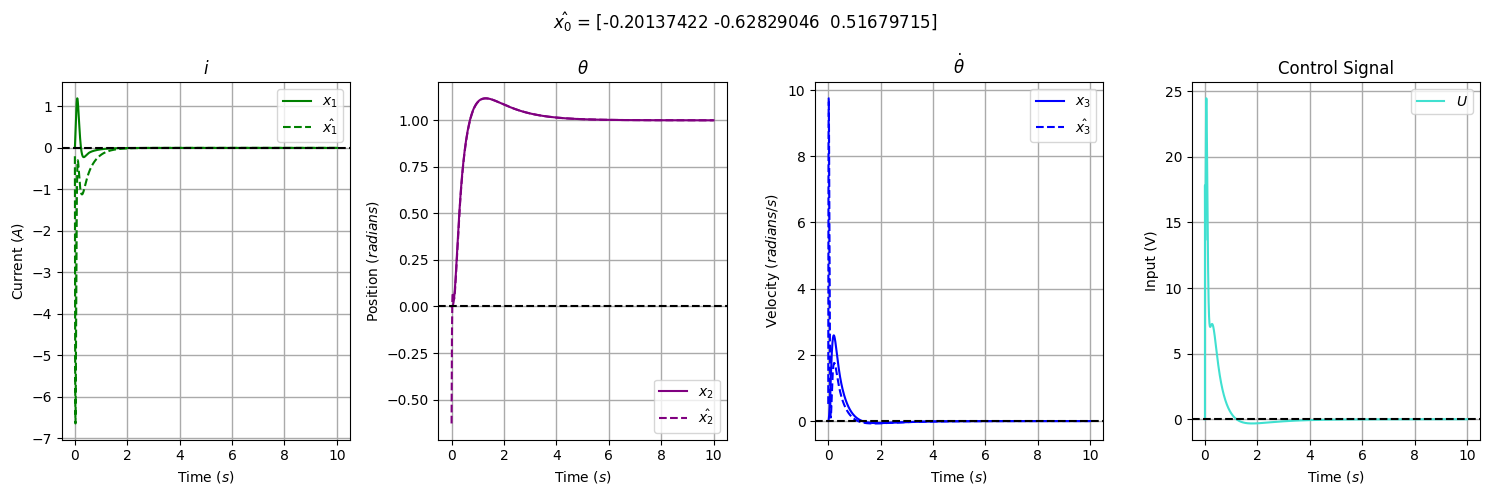

In [ ]:
duration = 10
delta_t = 0.001
xhat_0 = rand_xhat()
x_0 = np.array([0, 0, 0])

controller = StateFeedbackRegulator(K=K_final, k_f=K_f_final, setpoint=1)

plot_final(plant=dcmotor1,
            controller=controller,
            plant_est=estimator,
            x_0=x_0,
            xhat_0=xhat_0,
            duration=duration,
            delta_t=delta_t)

Yay! The estimates converge to the real states! After re-running that cell a few times, the outputs make sense: the $\hat{x}$ values begin at their initial states, and then typically within $<2$ seconds they converge on the real values. Super cool to see! 

Now to directly compare the input signals for each version: with and without the state estimator.

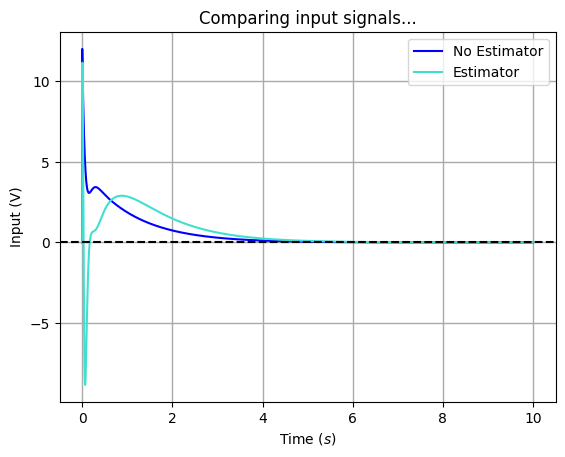

In [ ]:
results = simulate(plant=dcmotor1,
                   controller=controller,
                   x_0=x_0,
                   t_0=0,
                   t_f=duration,
                   delta_t=delta_t)

est_results = simulate_final(plant=dcmotor1,
                             controller=controller,
                             plant_est=estimator,
                             x_0=x_0,
                             xhat_0=xhat_0,
                             t_0=0,
                             t_f=duration,
                             delta_t=delta_t)
fig = plt.figure()
plt.plot(results[0], results[2], label="No Estimator", color="blue")
plt.plot(est_results[0], est_results[3], label="Estimator", color="turquoise")
plt.grid(visible=True, which='major', color='#AAAAAA', linewidth=1.0)
plt.ylabel(r"Input (V)")
plt.xlabel("Time $(s)$")
plt.legend()
plt.axhline(y=0, color='k', linestyle="dashed")
plt.title("Comparing input signals...")
plt.show()

So, it's impossible for me to evaluate the exact version of whatever plot gets generated when you read this since the inputs are randomized, but I can generalize based on what I've witnessed across about a dozen runs:

The version with the estimator drives much more extreme values at the beginning, when the $\hat{x}$ values are lying about the state of the system and the state feedback regulator thinks it's going 2 $\frac{rad}{s}$ initially and pumps a bunch of negative voltage to slow it down. But, as the estimations converge with reality, the input comes back down to what we want and eventually approaches to zero as we near our setpoint.

# Reflection
Overall, this was a really cool practicum! It feels cool to be able to come back to that asterisk (*) we saw at the beginning of the semester: that we will never know the true state of the system. Now we know how to estimate it! We've come full circle.

With the semester wrapping up, now I need to figure out how to export this code to my github somehow...